In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np
import subprocess
import datetime
import time

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from IPython.display import HTML
import xml.etree.ElementTree as ET
try:
    tree = ET.parse(os.environ['HADOOP_CONF_DIR'] + '/yarn-site.xml')
except IOError:
    raise IOError("Can't find the yarn configuration -- is HADOOP_CONF_DIR set?")

In [2]:
root = tree.getroot()
yarn_web_app = root.findall("./property[name='yarn.resourcemanager.webapp.address']")[0].find('value').text
yarn_web_app_string = "If this works successfully, you can check the <a target='_blank' href='http://{yarn_web_app}'>YARN application scheduler</a> and you should see your app listed there. Clicking on the 'Application Master' link will bring up the familiar Spark Web UI. "

Load spark configuration setup when executing notebook by https://github.com/rokroskar/spark_workshop

In [3]:
# configuration directory
os.environ['SPARK_CONF_DIR'] = os.path.realpath('../../spark_workshop/notebooks/twitter_dataframes/spark_config')

# number of cores
ncores = int(os.environ.get('LSB_DJOB_NUMPROC', 1)) 

# here we set the memory we want spark to use for the driver JVM
os.environ['SPARK_DRIVER_MEMORY'] = '%dG'%(ncores*0.7)

# python executable
os.environ['PYSPARK_PYTHON'] = subprocess.check_output('which python', shell=True).rstrip()

In [4]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, HiveContext
import pyspark.sql.functions as func
from pyspark.sql import Row, Window
from pyspark.sql.types import IntegerType, ArrayType, StringType, NullType, LongType, StructField, \
                              StructType, DateType, DataType, DateConverter, DatetimeConverter, \
                              TimestampType, BooleanType
from pyspark.ml.feature import Tokenizer, VectorAssembler
from pyspark.mllib.linalg import DenseVector

### Start context

In [5]:
conf = SparkConf()
sc = SparkContext(master='yarn-client', conf=conf)

### Load twitter data

In [6]:
hc = HiveContext(sc)

In [7]:
!hadoop fs -du -h /user/roskarr/twitter/

Picked up _JAVA_OPTIONS: -Xmx1024m -Xms256m -XX:ParallelGCThreads=1
16/05/04 12:50:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
55.1 G  /user/roskarr/twitter/2014_05
31.7 G  /user/roskarr/twitter/2014_06
51.0 G  /user/roskarr/twitter/2014_07
59.6 G  /user/roskarr/twitter/2014_09
61.9 G  /user/roskarr/twitter/2014_10
62.0 G  /user/roskarr/twitter/2014_11
12.1 G  /user/roskarr/twitter/2014_12


Read in the parquet files by Iza and Rok containing the twitter data

In [8]:
%%time
month = '11'
data = hc.read.parquet('/user/roskarr/twitter/2014_'+month+'*')

CPU times: user 13 ms, sys: 8 ms, total: 21 ms
Wall time: 27.3 s


### Pyspark configuration

In [9]:
sc._conf.getAll()

[(u'spark.yarn.executor.memoryOverhead', u'2048'),
 (u'spark.master', u'yarn-client'),
 (u'spark.sql.parquet.mergeSchema', u'true'),
 (u'spark.yarn.am.memory', u'8g'),
 (u'spark.executor.cores', u'4'),
 (u'spark.executor.instances', u'20'),
 (u'spark.app.name', u'twitter_dataframes'),
 (u'spark.shuffle.memoryFraction', u'0.2'),
 (u'spark.storage.memoryFraction', u'0.5'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.yarn.am.cores', u'4'),
 (u'spark.yarn.isPython', u'true'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.driver.memory', u'244G'),
 (u'spark.executor.memory', u'8g')]

### Read in our list containing the keywords

In [10]:
def get_keys(path='../docs/keywords.txt'):
    keys = np.genfromtxt(path, dtype="|S20", delimiter='#', autostrip=True)
    return set(keys.tolist())

In [11]:
keys = get_keys()
print(keys)

set(['influenza', 'pope', 'unemployment', 'london', 'asylum', 'birds', 'galaxy', 'islam', 'rosetta', 'sochi', 'black', 'sierra', 'whatsapp', 'homework', 'mandela', 'coffee', 'maya', 'watch', 'vegan', 'arab', 'facebook', 'foreigners', 'wedding', 'liberia', 'school', 'meat', 'philippines', 'refugees', 'right', 'spring', 'twitter', 'allah', 'crimea', 'sandy', 'god', 'hurricane', 'olympics', 'ebola', 'europe', 'christian', 'pasta', 'teacher', 'vaccine', 'ukraine', 'climate', 'vegetarian', 'jogging', 'swine', 'comet', 'apple', 'family', 'nsa', 'africa', 'epidemic', 'google', 'linux', 'usa', 'divorce', 'bitcoin', 'sports', 'doomsday', 'pc', 'attack', 'iphone', 'tea', 'white', 'banana', 'snowden', 'gluten', 'geneva', 'immigration', 'mh370', 'obama', 'television', 'migrants', 'isis', 'higgs', 'flu', 'marriage', 'russia', 'unhcr', 'mh17', 'boston', 'pig', 'work', 'marathon', 'italy', 'ethiopia', 'terrorism', 'putin', 'who', 'holidays', 'virus', 'curiosity', 'syria', 'crowded', 'nelson', 'guinea

In [12]:
keys_hashtag = set(['#'+key for key in list(get_keys())])
print(keys_hashtag)

set(['#whatsapp', '#epidemic', '#pig', '#olympics', '#terrorism', '#iphone', '#curiosity', '#gluten', '#linux', '#putin', '#watch', '#unemployment', '#virus', '#apple', '#galaxy', '#liberia', '#television', '#ukraine', '#white', '#bitcoin', '#marriage', '#usa', '#hurricane', '#foreigners', '#mh17', '#unhcr', '#work', '#immigration', '#europe', '#migrants', '#meat', '#asylum', '#jogging', '#divorce', '#pc', '#italy', '#comet', '#geneva', '#pope', '#holidays', '#coffee', '#russia', '#vaccine', '#nsa', '#doomsday', '#africa', '#guinea', '#mh370', '#sports', '#family', '#leone', '#snowden', '#homework', '#allah', '#crowded', '#sochi', '#teacher', '#philippines', '#syria', '#london', '#school', '#flu', '#vegetarian', '#left', '#sierra', '#right', '#nelson', '#google', '#vegan', '#ethiopia', '#sandy', '#swine', '#marathon', '#pasta', '#boston', '#mandela', '#christian', '#influenza', '#god', '#rosetta', '#ebola', '#crimea', '#climate', '#birds', '#obama', '#who', '#black', '#twitter', '#isla

### Custom functions performing operations on the columns

In [13]:
# Change the date format to YYYY-MM-DD HH:MM:SS
convert_date_string = func.udf(lambda date_string: datetime.date.strftime(datetime.datetime.strptime(date_string, \
                                                                           '%a %b %d %H:%M:%S +0000 %Y'),\
                                                                           '%Y-%m-%d %H:%M:%S'
                                                                         ), StringType())

# Convert the date string to a datetime object
datetime_udf = func.udf(lambda date_string: datetime.strptime(date_string, '%a %b %d %H:%M:%S +0000 %Y'), DateType())

# Map the datetime object column to a unique number for every day in any year
new_date = (lambda col: func.dayofyear(col) + func.year(col)*1000)

## Filter dataframe to contain only tweets with at least one appearance of one of the keywords

Number of partitions (set really high to avoid exit codes 52s (out of memory))

In [14]:
Npartitions = sc.defaultParallelism*80
print(Npartitions)

6400


In [15]:
tweets_df = (data.select('created_at', 'text')
                 .filter(func.length('text') > 0)
                 .withColumn('created_at', convert_date_string('created_at'))
                 .withColumn('created_at', new_date('created_at'))
             )

Use Tokenizer to force 'text' to be lowercase and split up into words

In [16]:
T = Tokenizer(inputCol="text", outputCol="words")
words_df = (T.transform(tweets_df)
             .select('created_at', 'words')
             .select('created_at', func.explode('words').alias('word'))
             .cache()
            )

## Filter the dataset further and reduce

With Pivot, we can have the date as columns and the individual words as different rows. Thus, then only the corresponding rows need to be selected and we get the histograms of each keywords.

In [17]:
word_counts_per_day_df = (words_df.groupBy('word')
                                  .pivot('created_at')  # Pivot will make the dates the headings of the columns
                                  .count())

Now, to get the distinct columns, the vector assembler is used, which takes together varies columns and merges them into arrays. These have the advantage, that the data for a given word is then in the format: Array(Counts for each day). Doing the same for the date, which are the columns names, gives a mapping on these counts to the days.

In [18]:
# Get the dates, which are unique members of the column in the words_df, and put them into an array
dates = (words_df.select('created_at')
                 .distinct()
                 .rdd
                 .map(lambda r: str(r.created_at))
                 .collect()
         )

dates_array = np.array(dates, dtype=np.int)

# Make sure that these entries are sorted (should be)
assert(np.all(np.sort(dates_array) == dates_array))

In [19]:
# Assemble the counts for each day into one column
va = VectorAssembler(inputCols=dates, outputCol='histogram')
histograms_df = va.transform(word_counts_per_day_df)

# Assert that these columns are ordered the same way as the dates-list
assert(dates == word_counts_per_day_df.columns[1:])

Now that we have the histograms for each word, we can make the histograms for the keywords

In [20]:
histograms = histograms_df.select('word', 'histogram').rdd.filter(lambda r: r.word in keys.union(keys_hashtag)).collect()

Some asserts to make sure that we understand the data and its format

In [21]:
words = []
for h in histograms:
    word, _ = h
    words += [word]

In [22]:
keys.difference(set(words))

set()

Plot first 10 keywords as a sanity check

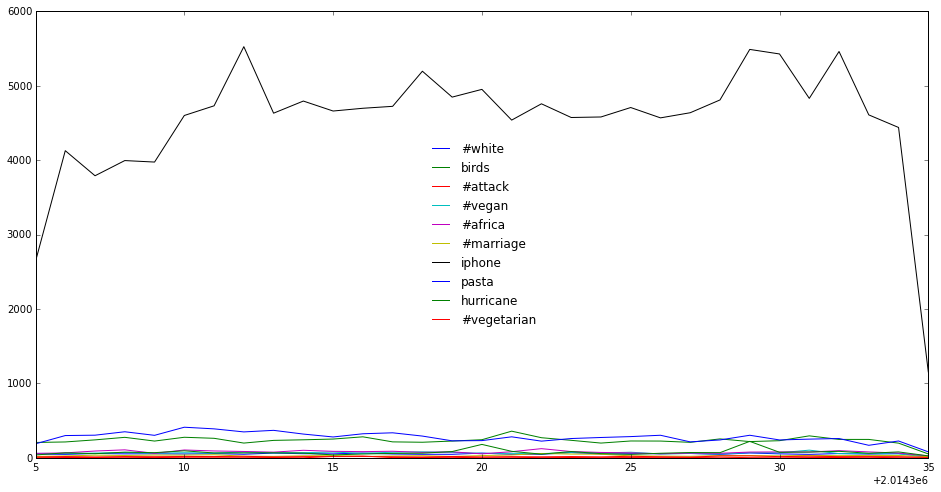

In [23]:
plt.figure(figsize=(16, 8))
for h in histograms[0:10]: 
    word, vec = h
    plt.plot(dates_array, vec, label=word)
plt.legend(loc='best', frameon=False)

Match keys with and without hashtags

In [24]:
words_wo_hashtags = [(words[i], i) for i in range(len(words)) if words[i][0] != '#']
words_w_hashtags = [(words[i][1:], i) for i in range(len(words)) if words[i][0] == '#']
length = max(len(words_wo_hashtags), len(words_w_hashtags))

In [25]:
words_wo_hashtags = [words[i] for i in range(len(words)) if words[i][0] != '#']
words_w_hashtags = [words[i][1:] for i in range(len(words)) if words[i][0] == '#']

words_no_hashtags = set(words_wo_hashtags).union(words_w_hashtags)
# ["foo", "bar", "baz"].index("bar")

In [26]:
words_indices = []

for word in words_no_hashtags:
    try:
        words_indices += [(word, words.index(word), words.index('#'+word))]
    except ValueError:
        try:
            words_indices += [(word, -1, words.index('#'+word))]
        except ValueError:
            words_indices += [(word, words.index(word), -1)]

Now, write the output as csv files

In [27]:
outdir = '/cluster/home/phys/bruclaud/Documents/spuriousrelations/data/'

In [28]:
for i in range(len(words_indices)):
    if words_indices[i][1] != -1 and words_indices[i][2] != -1:
        word, vec = histograms[words_indices[i][1]]
        vec = DenseVector(vec.toArray())
        _, vec_tmp = histograms[words_indices[i][2]]
        vec_tmp = DenseVector(vec_tmp.toArray())
        vec += vec_tmp
    elif words_indices[i][1] != -1:
        word, vec = histograms[words_indices[i][1]]
        vec = DenseVector(vec.toArray())
    elif words_indices[i][2] != -1:
        word, vec = histograms[words_indices[i][2]]
        word = word.lstrip('#')
        vec = DenseVector(vec.toArray())
    else:
        raise ValueError('This case cannot be.')

    csvlist = [k[0]+','+k[1] for k in zip(dates, map(str, map(int, vec)))]
    np.savetxt(outdir+word+'_'+month+'.csv', np.array(csvlist), fmt='%s')

In [29]:
sc.stop()